## Урок 3. Выбор и обучение модели на отобранных признаках. Сравнение качества и оценка модели

На одном из первых этапов решения любой задачи машинного обучения требуется собрать данные, которые позволят предсказывать целевую переменную. Перечень этих данных определяется, во-первых, технической воможностью сбора конкретных данных, а во-вторых, интуитивно понятной причинно-следственной связью. Исходя из собранных данных на этапе __data-mining__'а, производится далее формирование признакового пространства - __feature engineering__. Разумеется, не все полученные признаки будут в равной степени иметь предсказательную значимость: какие-то из признаков могут никак не улучшать обобщающую способность модели машинного обучения, а какие-то могут и вовсе вносить помехи в работу модели и ухудшать результат.

Процесс отбора признаков называется __feature selection__. Цель данного процесса - оставить в датасете только значимые признаки, уменьшить признаковое пространство. Отбор признаков позволяет, зачастую, улучшить качество модели, при этом уменьшит время обучения.

## Выбор модели

Задача бинарной классификации для вас хорошо уже знакома, поэтому подробно останавливаться на том, какие модели позволяют решить эту задача, не будем. Напомним лишь, что мы можем использовать для этой задачи какие-то простые модели, например, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, или же более сложные ансамбли - RandomForestClassifier, XGBClassifier, CatBoostClassifier, LGBMClassifier и т.д. Для некоего базового решения (__baseline__) воспользуемся реализацией XGBoost из sklearn с фиксированными параметрами модели.

Также напишем пару вспомогательных функций для оценки качества и отрисовки графиков.

In [7]:
#!pip install xgboost

  Using cached xgboost-1.0.2-py3-none-win_amd64.whl (24.6 MB)


In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

C:\Users\mailf\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\mailf\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [7]:

dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)



In [8]:
# Снизим дизбаланс классов
sm=SMOTE(random_state=42, sampling_strategy=0.3,n_jobs=1)
sm

SMOTE(k_neighbors=5, n_jobs=1, random_state=42, sampling_strategy=0.3)

In [9]:
X_train_balanced, y_train_balanced = sm.fit_sample(X_train, y_train)

## Методы отбора признаков

Существуют различные способы отбора признаков. Рассмотрим некоторые из существующих подходов.

### Feature Importance, как атрибут модели

Некоторые модели, такие как XGBoost, LGBMClassifier, RandomForestRegressor и др., имеют атрибут __feature\_importances\___, который показывает, насколько важен каждый из признаков. Эта "важность" может расчитываться как, например, путем суммирования прироста качества при разбиении узлов дерева по этому признаку, или же равняться количеству разбиений в дереве, которые произошли по данному признаку.

Посмотрим на примере XGBoost, как это выглядит.

Precision: 0.2917823884986113
Recall: 0.4305689488910318
F1: 0.34784302268964845
Log Loss: 0.1333354276834588
ROC AUC: 0.8988205314092221


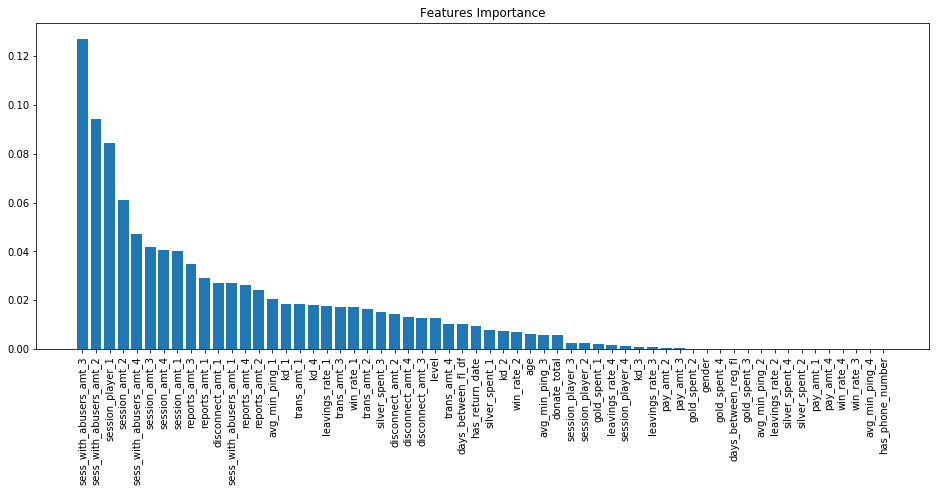

In [6]:

fitted_clf_basic = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf_basic.feature_importances_, X.columns, 'Features Importance')

Попробуем обучить модель на Топ-30 признаках и оценить качество.

In [27]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.2933135704874835
Recall: 0.4293635486981678
F1: 0.34853228962818
Log Loss: 0.1325140621657626
ROC AUC: 0.9007638522126366
Признаков было: 60
Признаков стало: 30


Видим, что кол-во признаков уменьшили __вдвое__, а качество практически не изменилось.

### Хи-квадрат

Данный способ позволяет отбирать признаки, используя статистический тест о зависимости между признаком и целевой переменной. Тест Хи-квадрат применяется в статистике для проверки независиости двух событий. Чем больше значение статистики Хи-квадрат, тем больше сильна завиимости между признаком и таргетом. Рассчитаем статистику и отберем признаки.

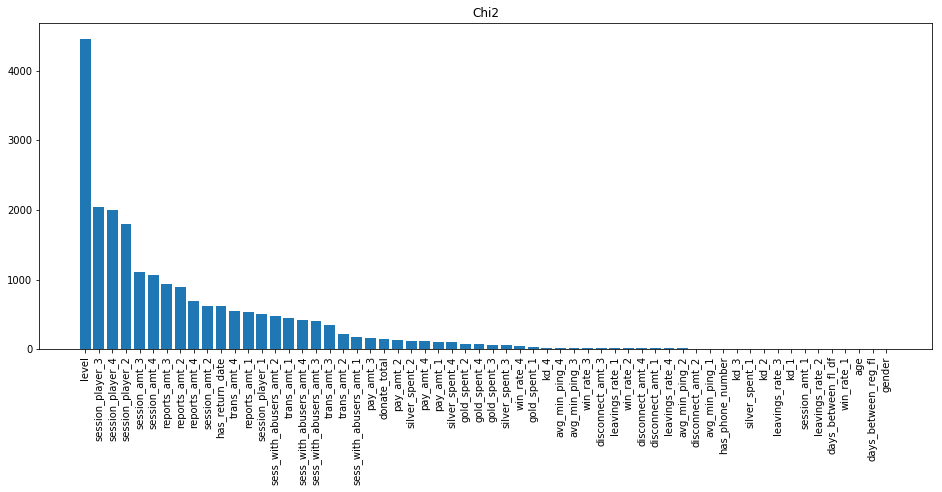

In [29]:

# Обратитевнимание, что значения в датасете должны быть неотрицательными для расчета Хи квартат
chi2_test = chi2(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(chi2_test[0], X.columns, 'Chi2')

Попробуем обучить модель на Топ-30 признаков и оценить качество.

In [30]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.28203445447087777
Recall: 0.4144165863066538
F1: 0.33564385433954896
Log Loss: 0.14916792855014038
ROC AUC: 0.8246239922106606


Видим, что на отобранных Хи-квадратом признаках качество упало сильнее, чем при отборе Feature Impotrance модели, но в целом так же незначительно.

### Взаимная информация

Отбор признаков на основании значения [взаимной информации](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%B0%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F).

In [31]:

mi = mutual_info_classif(X_train_balanced, y_train_balanced)

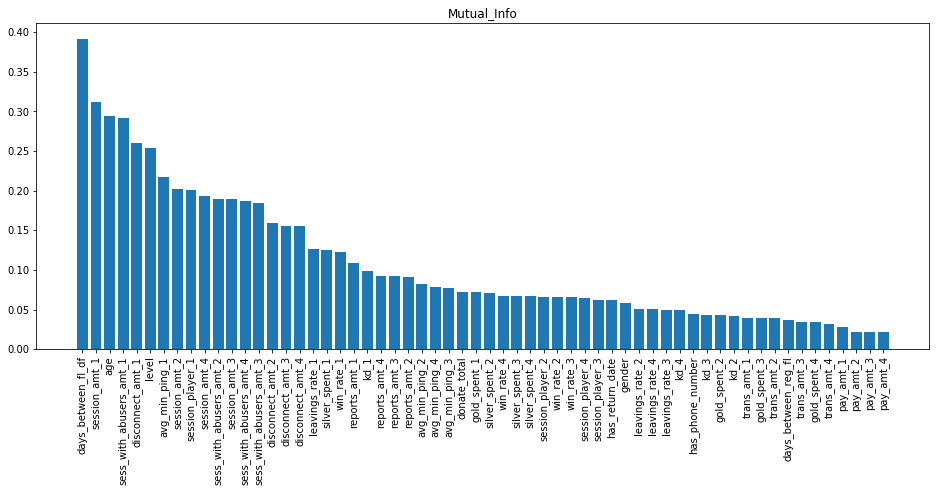

In [38]:
feature_importance_MI = plot_importance(mi, X.columns, 'Mutual_Info')

Для данного подхода и следующих в качестве __домашнего задания__ предлагается выбрать N лучших признаков по рассчитанной метрике и посмотреть качество предсказания на них.

In [40]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance_MI[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance_MI[0][:30]]

fitted_clf = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_MI.shape[1])

Precision: 0.29557616839100964
Recall: 0.39946962391513985
F1: 0.3397580479803158
Log Loss: 0.13247980938092146
ROC AUC: 0.8953904251498815
Признаков было: 60
Признаков стало: 30


### RFE (Recursive Feature Elimination)

Рекурскивный отсев признаков - убираем на каждой итерации самые слабые признаки и делаем это до тех пор, пока не увидим заметного снижения качества. На каком кол-ве признаков остановимся, то и считаем оптимальным.

In [41]:

STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 45


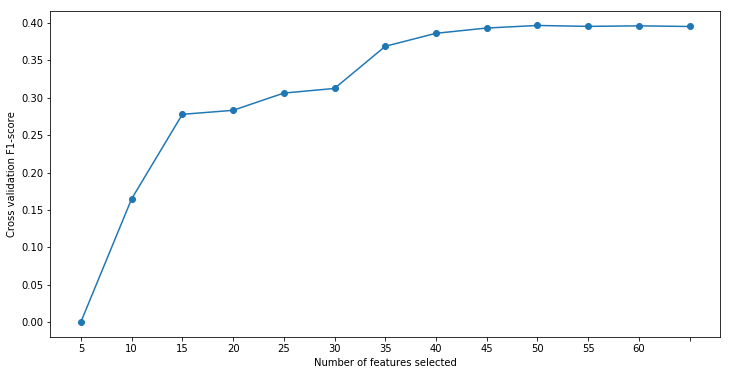

In [42]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [44]:
len(good_features)

45

In [45]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_RFE.shape[1])

Precision: 0.29409775071875527
Recall: 0.41923818707810995
F1: 0.34569128317264686
Log Loss: 0.13218474647064385
ROC AUC: 0.900158027837421
Признаков было: 60
Признаков стало: 45


### Permutation Importance (PI)

Перемешивание значений столбца важного признака приводит к заметному снижению качества работы модели

In [7]:
# Модуль можно установить, сделав
#!pip install eli5
# А можно использовать локальный модуль
from eli5.sklearn import PermutationImportance

In [8]:

perm = PermutationImportance(fitted_clf_basic, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

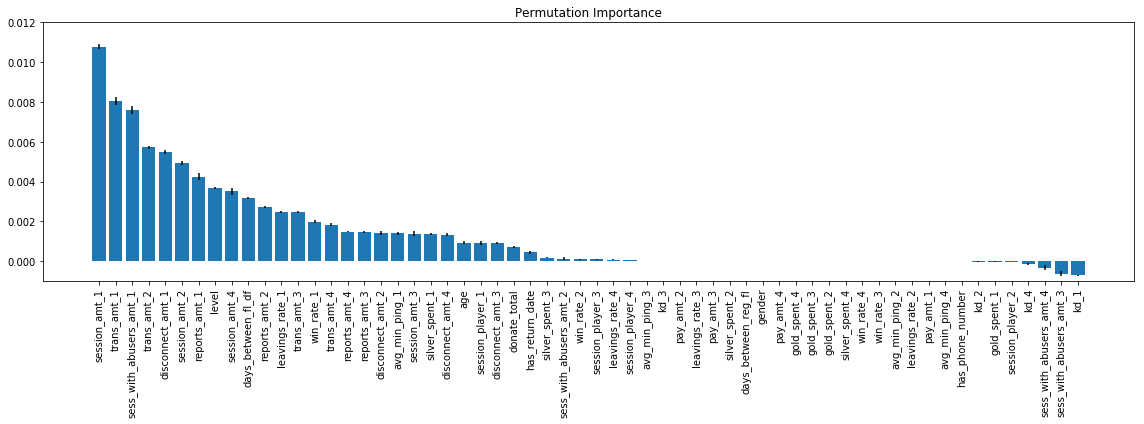

In [9]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [10]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 38


In [12]:
X_train_PI= pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_PI = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_PI.shape[1])

Precision: 0.2881638088896288
Recall: 0.4173095467695275
F1: 0.34091580502215657
Log Loss: 0.1329494683946994
ROC AUC: 0.8985121351996679
Признаков было: 60
Признаков стало: 38


## Задание 2. 
Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rfc_model=RandomForestClassifier()


In [26]:
rfc_model.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
predict_proba_test = rfc_model.predict_proba(X_test)
predict_test = rfc_model.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.37764574823616787
Recall: 0.24517839922854387
F1: 0.2973249524923257
Log Loss: 0.11704259140760055
ROC AUC: 0.9031022095414539


### SGDClassifier

In [1]:
from sklearn.linear_model import SGDClassifier

In [12]:
SGD_model=SGDClassifier(loss="log")

In [13]:
SGD_model.fit(X_train_balanced, y_train_balanced)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
predict_proba_test = SGD_model.predict_proba(X_test)
predict_test = SGD_model.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.23324905183312264
Recall: 0.08895853423336547
F1: 0.1287958115183246
Log Loss: 0.27913485030613705
ROC AUC: 0.7563084964545477


## Задание 3.
Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

добавим к признакам целевую переменную и посмотрим корреляцию признаков с ней

In [15]:
data_balanced=X_train_balanced.copy()

In [29]:
data_balanced_df=pd.DataFrame(data_balanced, columns=X.columns)

In [34]:
data_balanced_df.head()

,level,donate_total,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,...,gold_spent_1,gold_spent_2,gold_spent_3,gold_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
0,0.275,0.001340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.232877,1.0,0.000394,0.005589,1.0,1.0
1,0.350,0.001377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.315068,1.0,0.000394,0.463115,1.0,1.0
2,0.300,0.003847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.260274,1.0,0.000394,0.000373,0.0,1.0
3,0.425,0.003994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000332,0.002955,0.0,0.0,0.232877,1.0,0.000394,0.032042,1.0,1.0
4,0.025,0.000574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.003791,0.0,0.0,0.246575,1.0,0.000394,0.008197,1.0,1.0


In [36]:
target_balanced=y_train_balanced.copy()

In [37]:
target_balanced=target_balanced.to_numpy()

In [40]:
target_balanced

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [42]:
data_balanced_df['Target']=target_balanced

In [45]:
data_balanced_corr=data_balanced_df.corr()

In [65]:
target_corr=data_balanced_corr['Target']
target_corr=target_corr.drop(['Target'])

Отберем признаки, у которых корреляция с таргетом >0.1 по модулю

In [76]:
good_features=target_corr[abs(target_corr)>0.1].index
good_features

Index(['level', 'donate_total', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3',
       'trans_amt_4', 'reports_amt_1', 'reports_amt_2', 'reports_amt_3',
       'reports_amt_4', 'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4', 'session_amt_2',
       'session_amt_3', 'session_amt_4', 'win_rate_4', 'session_player_1',
       'session_player_2', 'session_player_3', 'session_player_4',
       'has_return_date'],
      dtype='object')

In [77]:
X_train_corr= pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_corr = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_corr, y_train_balanced, X_test_corr, y_test)

print('Признаков было:', X_train.shape[1])


Precision: 0.28153264265745764
Recall: 0.4127290260366442
F1: 0.3347345781601329
Log Loss: 0.148642756809722
ROC AUC: 0.8251303114370684
Признаков было: 60


NameError: name 'X_train_PI' is not defined

In [78]:
print('Признаков стало:', X_train_corr.shape[1])

Признаков стало: 23


### WoE (Weight of Evidence) and IV (Information Value)

Простое, но в то же время мощное преобразование данных, позволяющее установить монотонную связь между признаками и целевой переменной, а IV может использоваться как мера важности признаков. Преобразование осуществляет корректную обработку как пропущенных значений, так и выбросов, поэтому предварительно обрабатывать датасет не нужно для WOE.

In [24]:
# Для простоты расчетов используем локальный модуль
from WOE_IV import data_vars

dataset_raw = pd.read_csv('dataset/dataset_raw_train.csv', sep=';')
X_raw = dataset_raw.drop(['user_id', 'is_churned'], axis=1)
y_raw = dataset_raw['is_churned']

In [25]:
%%time
# Рассчитаем IV
iv_df, iv = data_vars(X_raw, y_raw)

CPU times: user 29.6 s, sys: 96 ms, total: 29.7 s
Wall time: 29.7 s


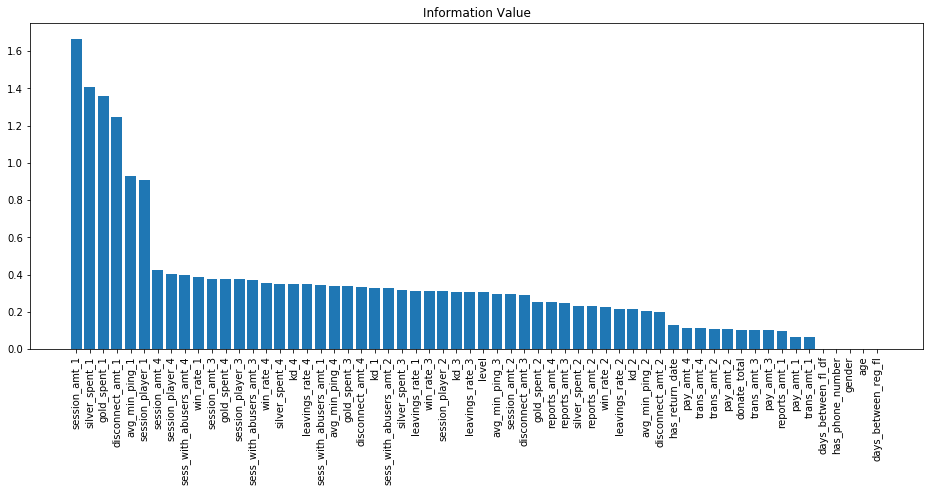

In [26]:
IV = iv.sort_values('IV', ascending=False)
plt.figure(figsize=(16,6))
plt.bar(range(IV.shape[0]), IV['IV'], align='center')
plt.xticks(range(IV.shape[0]), IV['VAR_NAME'].values, rotation=90)
plt.title('Information Value')
plt.show()

In [27]:
%%time
X_WOE = X_raw.copy()

for var in X_WOE.columns:
    small_df = iv_df.loc[iv_df['VAR_NAME'] == var]
    if type(small_df.loc[~small_df['MIN_VALUE'].isnull()]['MIN_VALUE'].values[0]) == str:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 'NaN'
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 'NaN'
    else:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 0.
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 0.
    transform_dict = dict(zip(small_df['MAX_VALUE'], small_df['WOE']))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd += str(i[1]) + ' if x <= ' + str(i[0]) + ' else '
        replace_cmd1 += str(i[1]) + ' if x == "' + str(i[0]) + '" else '
    replace_cmd += '0'
    replace_cmd1 += '0'
    if replace_cmd != '0':
        try:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd))
        except:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd1))

CPU times: user 10min 53s, sys: 2.12 s, total: 10min 55s
Wall time: 10min 55s


In [28]:
X_train_WOE, X_test_WOE, y_train_WOE, y_test_WOE = train_test_split(X_WOE, 
                                                                    y_raw, 
                                                                    test_size=0.3,
                                                                    shuffle=True, 
                                                                    stratify=y_raw, 
                                                                    random_state=100)
X_train_WOE_balanced, y_train_WOE_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train_WOE, y_train_WOE)

In [29]:
# Выделим значимые признаки, для таких признаков IV не должно быть близко ни к 0, ни к 1
significant_features = IV.loc[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']
print('Значимых признаков:', significant_features.nunique())

Значимых признаков: 49


Из-за установления монотонной связи WOE преобразование тесно связано с логистической регрессией и в некотором смысле "подготавливает" датасет для logit'а. Посмотрим, какое качество получается на WOE датасете у логистической регрессии и сравним это с качеством на "обычном".

In [31]:
%%time
logit = LogisticRegression(random_state=42)
logit.fit(X_train_WOE_balanced, y_train_WOE_balanced)

predict_proba_test = logit.predict_proba(X_test_WOE)
predict_test = logit.predict(X_test_WOE)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, predict_test, predict_proba_test[:, 1])

Precision: 0.22877593548971642
Recall: 0.6087270973963356
F1: 0.33256503128086934
Log Loss: 0.19276677834867018
ROC AUC: 0.8942413528023079
CPU times: user 18 s, sys: 132 ms, total: 18.1 s
Wall time: 18.1 s


In [32]:
%%time
logit_2 = LogisticRegression(random_state=42)
logit_2.fit(X_train_balanced, y_train_balanced)

predict_proba_test = logit_2.predict_proba(X_test)
predict_test = logit_2.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.20547709266276265
Recall: 0.2876084860173578
F1: 0.23970263210769538
Log Loss: 0.2567466704472412
ROC AUC: 0.7784668074964207
CPU times: user 9.93 s, sys: 36 ms, total: 9.97 s
Wall time: 9.97 s


Как видим, WOE преобразованный датасет позволяет получить на дефолтном logit'е практически такое же качество, как XGBoost! При этом, для сравнения, тот же logit на обычном датасете показывает заметно худшее качество.

## Оценка качества модели

В качестве базового решения у нас модель XGBoost, которую мы обучили в начале урока. Проведем ее более комплексную оценку, для этого напишем несколько вспомогательных фукнций для более наглядной визуализации результатов.

In [33]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Precision: 0.3006002000666889
Recall: 0.4346673095467695
F1: 0.35541099940863397
Log Loss: 0.13189261621000226
ROC AUC: 0.8997680996797839


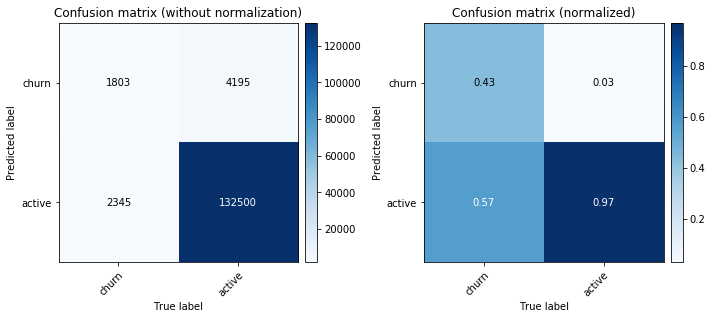

In [41]:
model = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

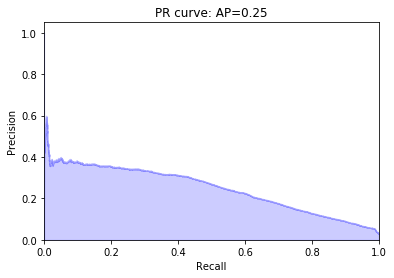

In [46]:
plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()

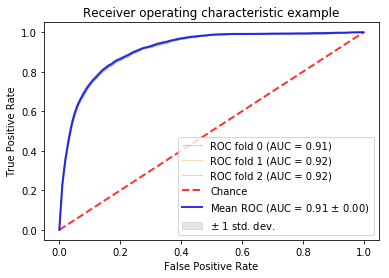

CPU times: user 39.3 s, sys: 324 ms, total: 39.6 s
Wall time: 8.18 s


In [58]:
%%time
plot_ROC_curve(classifier=model, 
               X=X_test, 
               y=y_test.values, 
               n_folds=3)

In [ ]:
# Итоговую модель можно сохранить в файл

# with open('models/baseline_xgb.pcl', 'wb') as f:
#     pickle.dump(model, f)

### Литература


1. [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
2. [sklearn.feature_selection ](https://scikit-learn.org/stable/modules/feature_selection.html)
3. [Feature Selection with sklearn and Pandas](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
4. [Weight of evidence and Information Value using Python](https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)
5. [Weight of Evidence(WOE) and Information Value(IV)](https://www.kaggle.com/pavansanagapati/weight-of-evidence-woe-information-value-iv)

### Д/З

1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?
2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.
3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.
4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 